**1. Load and Explore Data**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('Corona_NLP_train.csv', encoding='latin1')

# Display the first few rows of the dataframe
print(df.head())


   UserName  ScreenName   Location     TweetAt  \
0      3799       48751     London  16-03-2020   
1      3800       48752         UK  16-03-2020   
2      3801       48753  Vagabonds  16-03-2020   
3      3802       48754        NaN  16-03-2020   
4      3803       48755        NaN  16-03-2020   

                                       OriginalTweet           Sentiment  
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral  
1  advice Talk to your neighbours family to excha...            Positive  
2  Coronavirus Australia: Woolworths to give elde...            Positive  
3  My food stock is not the only one which is emp...            Positive  
4  Me, ready to go at supermarket during the #COV...  Extremely Negative  


In [2]:

# Display dataset information
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [3]:
# Check for missing values
print(df.isnull().sum())



UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64


In [4]:
# Distribution of sentiments
print(df['Sentiment'].value_counts())


Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64


2. EDA

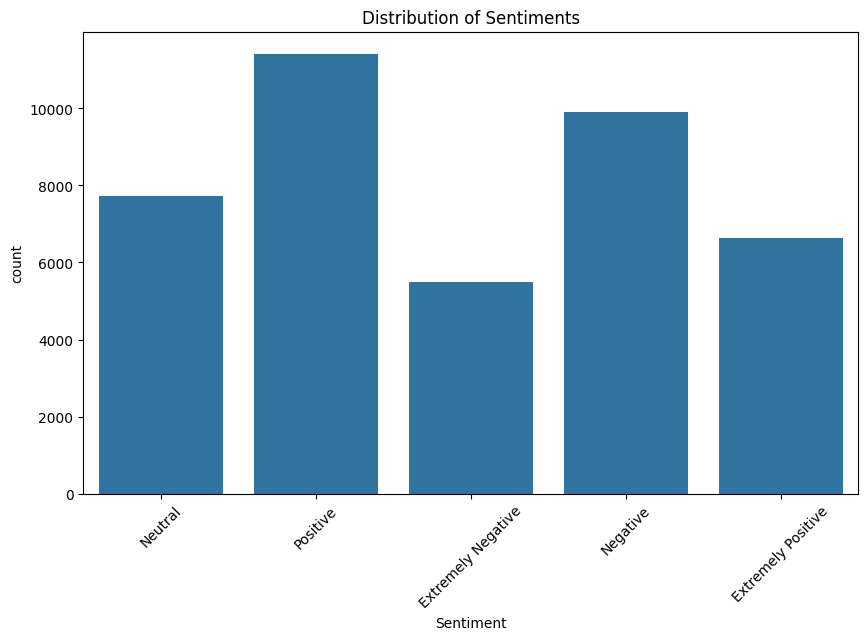

In [5]:
# Distribution of sentiments
plt.figure(figsize=(10, 6))
sns.countplot(x='Sentiment', data=df)
plt.title('Distribution of Sentiments')
plt.xticks(rotation=45)
plt.show()

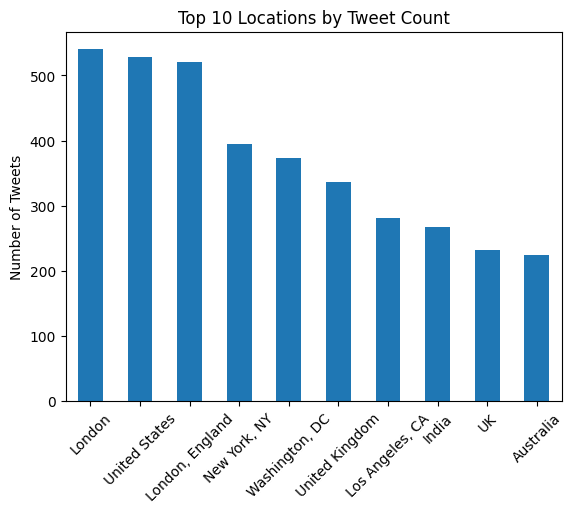

In [6]:
# Top 10 locations by tweet count
top_locations = df['Location'].value_counts().head(10)
top_locations.plot(kind='bar')
plt.title('Top 10 Locations by Tweet Count')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.show()

3. Data Preprocessing


In [7]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

# Preprocessing function
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    text = re.sub(r'\@\w+|\#','', text)
    # Remove punctuations
    text = re.sub(r'[^\w\s]', '', text)
    # Lowercase
    text = text.lower()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    word_tokens = text.split()
    filtered_text = [word for word in word_tokens if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(word) for word in filtered_text]
    return " ".join(lemmatized_text)

# Apply preprocessing
df['processed_tweets'] = df['OriginalTweet'].apply(lambda x: preprocess_text(x))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


4. Model Implementation

Naive Bayes

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(df['processed_tweets'], df['Sentiment'], test_size=0.2, random_state=42)

# Vectorize the text
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

# Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_counts, y_train)

# Predictions
predictions = nb_classifier.predict(X_test_counts)

# Evaluation
print(classification_report(y_test, predictions))
print("Accuracy: ", accuracy_score(y_test, predictions))


                    precision    recall  f1-score   support

Extremely Negative       0.61      0.34      0.43      1056
Extremely Positive       0.59      0.40      0.47      1330
          Negative       0.42      0.51      0.46      2006
           Neutral       0.68      0.30      0.42      1553
          Positive       0.41      0.65      0.50      2287

          accuracy                           0.47      8232
         macro avg       0.54      0.44      0.46      8232
      weighted avg       0.52      0.47      0.46      8232

Accuracy:  0.46902332361516036


Hyperparameter Tuning

In [9]:
from sklearn.model_selection import GridSearchCV

# GridSearch for hyperparameter tuning
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5)
grid_search.fit(X_train_counts, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))


Best parameters: {'alpha': 1}
Best cross-validation score: 0.46


In [10]:
# Assuming you've found the best alpha value from GridSearchCV as follows
best_alpha = grid_search.best_params_['alpha']

# Re-train the Naive Bayes classifier with the best alpha
optimized_nb_classifier = MultinomialNB(alpha=best_alpha)
optimized_nb_classifier.fit(X_train_counts, y_train)

# Predictions with the optimized model
optimized_predictions = optimized_nb_classifier.predict(X_test_counts)

# Evaluation
print(classification_report(y_test, optimized_predictions))
print("Accuracy: ", accuracy_score(y_test, optimized_predictions))


                    precision    recall  f1-score   support

Extremely Negative       0.61      0.34      0.43      1056
Extremely Positive       0.59      0.40      0.47      1330
          Negative       0.42      0.51      0.46      2006
           Neutral       0.68      0.30      0.42      1553
          Positive       0.41      0.65      0.50      2287

          accuracy                           0.47      8232
         macro avg       0.54      0.44      0.46      8232
      weighted avg       0.52      0.47      0.46      8232

Accuracy:  0.46902332361516036


Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

# Logistic Regression classifier
lr_classifier = LogisticRegression(random_state=42, max_iter=1000)

# Train the model
lr_classifier.fit(X_train_counts, y_train)

# Predictions
lr_predictions = lr_classifier.predict(X_test_counts)

# Evaluation
print(classification_report(y_test, lr_predictions))
print("Accuracy: ", accuracy_score(y_test, lr_predictions))


                    precision    recall  f1-score   support

Extremely Negative       0.65      0.58      0.61      1056
Extremely Positive       0.70      0.63      0.66      1330
          Negative       0.55      0.53      0.54      2006
           Neutral       0.63      0.71      0.67      1553
          Positive       0.58      0.61      0.59      2287

          accuracy                           0.61      8232
         macro avg       0.62      0.61      0.61      8232
      weighted avg       0.61      0.61      0.61      8232

Accuracy:  0.607871720116618


In [12]:
# Hyperparameter tuning using GridSearchCV
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
}

grid_search_lr = GridSearchCV(LogisticRegression(random_state=42, max_iter=1000), param_grid_lr, cv=5, scoring='accuracy')
grid_search_lr.fit(X_train_counts, y_train)

# Best parameters and best score
print("Best parameters for Logistic Regression:", grid_search_lr.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search_lr.best_score_))

# Train with the best parameters
best_params_lr = grid_search_lr.best_params_
optimized_lr_classifier = LogisticRegression(random_state=42, max_iter=1000, **best_params_lr)
optimized_lr_classifier.fit(X_train_counts, y_train)

# Predictions with the optimized model
optimized_lr_predictions = optimized_lr_classifier.predict(X_test_counts)

# Evaluation with the optimized model
print(classification_report(y_test, optimized_lr_predictions))
print("Accuracy with optimized Logistic Regression: ", accuracy_score(y_test, optimized_lr_predictions))


Best parameters for Logistic Regression: {'C': 1, 'solver': 'lbfgs'}
Best cross-validation score: 0.59
                    precision    recall  f1-score   support

Extremely Negative       0.65      0.58      0.61      1056
Extremely Positive       0.70      0.63      0.66      1330
          Negative       0.55      0.53      0.54      2006
           Neutral       0.63      0.71      0.67      1553
          Positive       0.58      0.61      0.59      2287

          accuracy                           0.61      8232
         macro avg       0.62      0.61      0.61      8232
      weighted avg       0.61      0.61      0.61      8232

Accuracy with optimized Logistic Regression:  0.607871720116618


LSTM

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenization
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['processed_tweets'])
sequences = tokenizer.texts_to_sequences(df['processed_tweets'])

# Padding
max_length = max([len(x) for x in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Splitting the dataset
import numpy as np
labels = pd.get_dummies(df['Sentiment']).values  # Converting categorical labels to numerical
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(np.array(padded_sequences), labels, test_size=0.2, random_state=42)


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

# Model configuration
embedding_dim = 64

# Model definition
model = Sequential([
    Embedding(input_dim=10000, output_dim=embedding_dim, input_length=max_length),
    Bidirectional(LSTM(units=64, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=32)),
    Dense(units=24, activation='relu'),
    Dropout(0.2),
    Dense(units=labels.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 46, 64)            640000    
                                                                 
 bidirectional (Bidirection  (None, 46, 128)           66048     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 46, 128)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 24)                1560      
                                                                 
 dropout_1 (Dropout)         (None, 24)                0

In [15]:
# Model training
epochs = 10
batch_size = 32

history = model.fit(X_train_seq, y_train_seq, epochs=epochs, batch_size=batch_size, validation_data=(X_test_seq, y_test_seq), verbose=1)


Epoch 1/10
1029/1029 [==============================] - 112s 100ms/step - loss: 1.2418 - accuracy: 0.4700 - val_loss: 0.8716 - val_accuracy: 0.6648
Epoch 2/10
1029/1029 [==============================] - 100s 97ms/step - loss: 0.7561 - accuracy: 0.7324 - val_loss: 0.7640 - val_accuracy: 0.7232
Epoch 3/10
1029/1029 [==============================] - 101s 98ms/step - loss: 0.6106 - accuracy: 0.7935 - val_loss: 0.7471 - val_accuracy: 0.7347
Epoch 4/10
1029/1029 [==============================] - 100s 97ms/step - loss: 0.5166 - accuracy: 0.8328 - val_loss: 0.7720 - val_accuracy: 0.7304
Epoch 5/10
1029/1029 [==============================] - 102s 99ms/step - loss: 0.4362 - accuracy: 0.8612 - val_loss: 0.8404 - val_accuracy: 0.7264
Epoch 6/10
1029/1029 [==============================] - 101s 98ms/step - loss: 0.3632 - accuracy: 0.8859 - val_loss: 0.9910 - val_accuracy: 0.7149
Epoch 7/10
1029/1029 [==============================] - 105s 102ms/step - loss: 0.3116 - accuracy: 0.9027 - val_loss:

In [16]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_seq, y_test_seq, verbose=1)
print(f'Test Accuracy: {accuracy*100:.2f}%')


258/258 [==============================] - 6s 25ms/step - loss: 1.3664 - accuracy: 0.6930
Test Accuracy: 69.30%


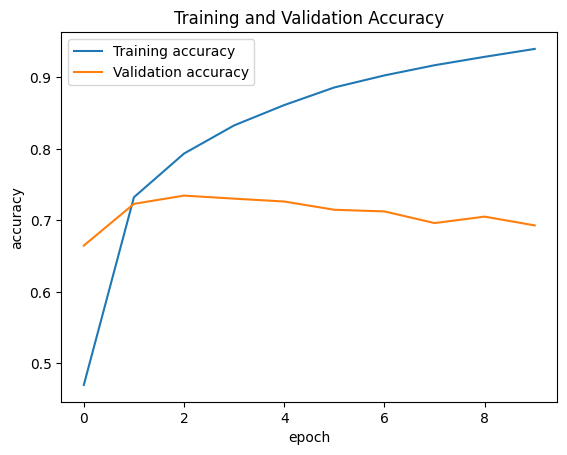

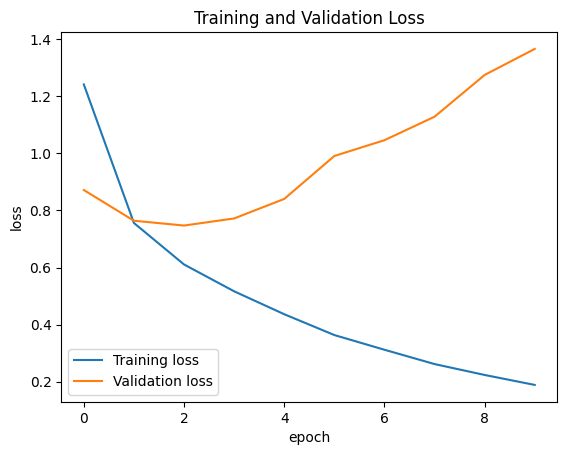

In [17]:
# Plotting training history
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()


**CNN**

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

# Model configuration
embedding_dim = 64
filter_sizes = [3, 4, 5]
num_filters = 64
dropout_rate = 0.5

# Model definition
cnn_model = Sequential([
    Embedding(input_dim=10000, output_dim=embedding_dim, input_length=max_length),
    Dropout(dropout_rate),
    Conv1D(filters=num_filters, kernel_size=filter_sizes[0], activation='relu'),
    GlobalMaxPooling1D(),
    Dense(units=128, activation='relu'),
    Dropout(dropout_rate),
    Dense(units=labels.shape[1], activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 46, 64)            640000    
                                                                 
 dropout_2 (Dropout)         (None, 46, 64)            0         
                                                                 
 conv1d (Conv1D)             (None, 44, 64)            12352     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                      

In [19]:
# Model training
epochs = 10
batch_size = 32

cnn_history = cnn_model.fit(X_train_seq, y_train_seq, epochs=epochs, batch_size=batch_size, validation_data=(X_test_seq, y_test_seq), verbose=1)

# Evaluate the model
loss, accuracy = cnn_model.evaluate(X_test_seq, y_test_seq, verbose=1)
print(f'Test Accuracy: {accuracy*100:.2f}%')

Epoch 1/10
1029/1029 [==============================] - 26s 23ms/step - loss: 1.2673 - accuracy: 0.4523 - val_loss: 0.9839 - val_accuracy: 0.6153
Epoch 2/10
1029/1029 [==============================] - 17s 16ms/step - loss: 0.9156 - accuracy: 0.6435 - val_loss: 0.8623 - val_accuracy: 0.6730
Epoch 3/10
1029/1029 [==============================] - 15s 14ms/step - loss: 0.8031 - accuracy: 0.6897 - val_loss: 0.8230 - val_accuracy: 0.6887
Epoch 4/10
1029/1029 [==============================] - 15s 15ms/step - loss: 0.7339 - accuracy: 0.7241 - val_loss: 0.8077 - val_accuracy: 0.6966
Epoch 5/10
1029/1029 [==============================] - 15s 15ms/step - loss: 0.6863 - accuracy: 0.7401 - val_loss: 0.8157 - val_accuracy: 0.6976
Epoch 6/10
1029/1029 [==============================] - 16s 16ms/step - loss: 0.6428 - accuracy: 0.7614 - val_loss: 0.8414 - val_accuracy: 0.6947
Epoch 7/10
1029/1029 [==============================] - 16s 15ms/step - loss: 0.6075 - accuracy: 0.7722 - val_loss: 0.8416 -

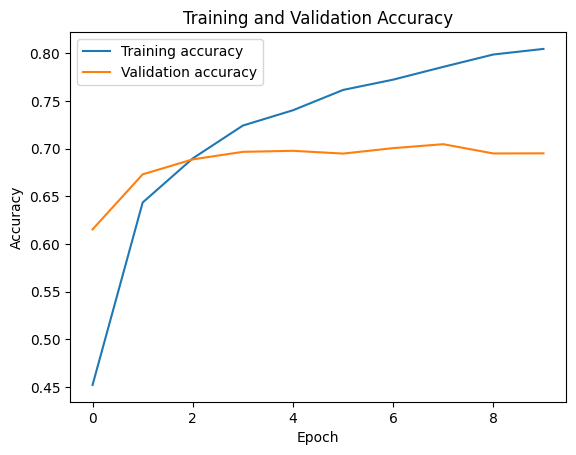

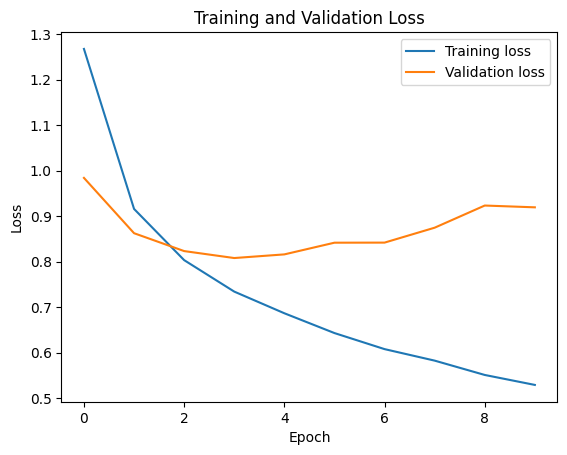

In [20]:
plt.plot(cnn_history.history['accuracy'], label='Training accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(cnn_history.history['loss'], label='Training loss')
plt.plot(cnn_history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()